# Load Dependencies

In [1]:
# load dependencies
from google.cloud import bigquery
from google.oauth2 import service_account

import pickle
import numpy as np
import pandas as pd
from numpy import asarray
from numpy import argmax

import imblearn
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPool1D
from tensorflow.keras.optimizers import Adam

2023-07-19 21:54:52.993333: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# define bigquery credentials
credentials = service_account.Credentials.from_service_account_file('path-to/gcp-redpandaq-admin.json')
project_id = 'redpandaq'

# initiate bigquery client
client = bigquery.Client(credentials= credentials,project=project_id)

# Load Dataset

In [3]:
# query data from Bigquery
query_job = client.query("""SELECT *
                            FROM fraud_detection.fraud_detection_train""")

results = query_job.result() 

In [4]:
# convert to dataframe
data = results.to_dataframe()
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,2827.0,-0.706598,0.974523,2.848002,1.624375,-0.247990,-0.084309,0.279253,0.190700,-0.511506,...,0.043665,0.206504,-0.097601,0.700411,-0.255074,-0.268562,0.131085,0.144414,0.0,0
1,4628.0,-0.839150,-0.058305,0.976245,0.679075,1.633833,-0.349848,-0.139845,0.058743,0.687350,...,-0.059531,-0.088113,-0.202860,-0.841774,0.029158,0.654090,0.019055,0.111575,0.0,0
2,9435.0,1.109195,0.281324,1.545027,2.725212,-0.542445,0.700936,-0.789461,0.276965,1.222948,...,-0.211894,-0.263569,0.009915,-0.067964,0.273979,-0.077881,0.009168,0.014901,0.0,0
3,5989.0,-0.441051,1.141001,2.901674,3.080502,-0.229397,0.930292,-0.232623,0.257068,0.599404,...,-0.215927,-0.234396,-0.276878,-0.211537,0.017965,0.237438,0.099152,0.086541,0.0,0
4,2828.0,1.181697,-0.007908,-0.066845,1.532223,1.728832,4.409885,-1.138816,1.164645,-0.020578,...,-0.139920,-0.399563,0.010200,0.992235,0.457015,-0.027924,0.045273,0.028868,0.0,0


# Exploratory Data Analysis

In [5]:
# checking null values
data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [6]:
# check dataframe information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15400 entries, 0 to 15399
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    15400 non-null  float64
 1   V1      15400 non-null  float64
 2   V2      15400 non-null  float64
 3   V3      15400 non-null  float64
 4   V4      15400 non-null  float64
 5   V5      15400 non-null  float64
 6   V6      15400 non-null  float64
 7   V7      15400 non-null  float64
 8   V8      15400 non-null  float64
 9   V9      15400 non-null  float64
 10  V10     15400 non-null  float64
 11  V11     15400 non-null  float64
 12  V12     15400 non-null  float64
 13  V13     15400 non-null  float64
 14  V14     15400 non-null  float64
 15  V15     15400 non-null  float64
 16  V16     15400 non-null  float64
 17  V17     15400 non-null  float64
 18  V18     15400 non-null  float64
 19  V19     15400 non-null  float64
 20  V20     15400 non-null  float64
 21  V21     15400 non-null  float64
 22

In [7]:
# check class count 
data['Class'].value_counts()

0    15000
1      400
Name: Class, dtype: Int64

In [8]:
# convert class column to float 
data['Class'] = data['Class'].astype('float64')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15400 entries, 0 to 15399
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    15400 non-null  float64
 1   V1      15400 non-null  float64
 2   V2      15400 non-null  float64
 3   V3      15400 non-null  float64
 4   V4      15400 non-null  float64
 5   V5      15400 non-null  float64
 6   V6      15400 non-null  float64
 7   V7      15400 non-null  float64
 8   V8      15400 non-null  float64
 9   V9      15400 non-null  float64
 10  V10     15400 non-null  float64
 11  V11     15400 non-null  float64
 12  V12     15400 non-null  float64
 13  V13     15400 non-null  float64
 14  V14     15400 non-null  float64
 15  V15     15400 non-null  float64
 16  V16     15400 non-null  float64
 17  V17     15400 non-null  float64
 18  V18     15400 non-null  float64
 19  V19     15400 non-null  float64
 20  V20     15400 non-null  float64
 21  V21     15400 non-null  float64
 22

# Separate Input and Output

In [9]:
# seperate input and output values
X_values = data.drop('Class', axis = 1)
y_values = data['Class']

In [10]:
# input values
X_values.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,2827.0,-0.706598,0.974523,2.848002,1.624375,-0.247990,-0.084309,0.279253,0.190700,-0.511506,...,-0.178859,0.043665,0.206504,-0.097601,0.700411,-0.255074,-0.268562,0.131085,0.144414,0.0
1,4628.0,-0.839150,-0.058305,0.976245,0.679075,1.633833,-0.349848,-0.139845,0.058743,0.687350,...,0.287608,-0.059531,-0.088113,-0.202860,-0.841774,0.029158,0.654090,0.019055,0.111575,0.0
2,9435.0,1.109195,0.281324,1.545027,2.725212,-0.542445,0.700936,-0.789461,0.276965,1.222948,...,-0.212773,-0.211894,-0.263569,0.009915,-0.067964,0.273979,-0.077881,0.009168,0.014901,0.0
3,5989.0,-0.441051,1.141001,2.901674,3.080502,-0.229397,0.930292,-0.232623,0.257068,0.599404,...,0.077805,-0.215927,-0.234396,-0.276878,-0.211537,0.017965,0.237438,0.099152,0.086541,0.0
4,2828.0,1.181697,-0.007908,-0.066845,1.532223,1.728832,4.409885,-1.138816,1.164645,-0.020578,...,-0.040382,-0.139920,-0.399563,0.010200,0.992235,0.457015,-0.027924,0.045273,0.028868,0.0


In [11]:
# output values
y_values[:5]

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Class, dtype: float64

# Train Test Split

In [12]:
# split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X_values, y_values, test_size = 0.2, random_state = 0, stratify = y_values)

# check shape of data
X_train.shape, X_test.shape

((12320, 30), (3080, 30))

## SMOTE oversampling

In [13]:
# apply smote oversampling
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [14]:
# summarize the new class distribution
from collections import Counter
counter = Counter(y_train)
print(counter)

Counter({0.0: 12000, 1.0: 12000})


# Scaling Data 

In [15]:
# create object of standard scaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# convert data to numpy arrays
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# save the scaler for future use
with open('data/StandardScaler.pkl','wb') as f:
    pickle.dump(scaler, f)

# Convert Data to 3-D for Neural Network

In [16]:
# convert data to 3-D
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [17]:
# check shape of data 
X_train.shape, X_test.shape

((24000, 30, 1), (3080, 30, 1))

# CNN Model for Classification

In [18]:
# define model architecture
epochs = 10
model = Sequential()

model.add(Conv1D(32, 2, activation='relu', input_shape = X_train[0].shape))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(64, 2, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 29, 32)            96        
                                                                 
 batch_normalization (BatchN  (None, 29, 32)           128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 29, 32)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 28, 64)            4160      
                                                                 
 batch_normalization_1 (Batc  (None, 28, 64)           256       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 28, 64)            0

In [19]:
# train model
model.compile(optimizer=Adam(lr=0.0001), loss = 'binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), verbose=1)

Epoch 1/10
750/750 [==============================] - 9s 9ms/step - loss: 0.0575 - accuracy: 0.9825 - val_loss: 0.0126 - val_accuracy: 0.9971
Epoch 2/10
750/750 [==============================] - 8s 10ms/step - loss: 0.0209 - accuracy: 0.9931 - val_loss: 0.0077 - val_accuracy: 0.9977
Epoch 3/10
750/750 [==============================] - 7s 9ms/step - loss: 0.0150 - accuracy: 0.9951 - val_loss: 0.0053 - val_accuracy: 0.9990
Epoch 4/10
750/750 [==============================] - 6s 9ms/step - loss: 0.0116 - accuracy: 0.9962 - val_loss: 0.0074 - val_accuracy: 0.9984
Epoch 5/10
750/750 [==============================] - 6s 8ms/step - loss: 0.0126 - accuracy: 0.9954 - val_loss: 0.0155 - val_accuracy: 0.9971
Epoch 6/10
750/750 [==============================] - 6s 8ms/step - loss: 0.0101 - accuracy: 0.9965 - val_loss: 0.0062 - val_accuracy: 0.9984
Epoch 7/10
750/750 [==============================] - 6s 8ms/step - loss: 0.0099 - accuracy: 0.9973 - val_loss: 0.0044 - val_accuracy: 0.9987
Epoch

In [20]:
# save model architecture and weights
model.save("data/fraud_detection_model.h5")

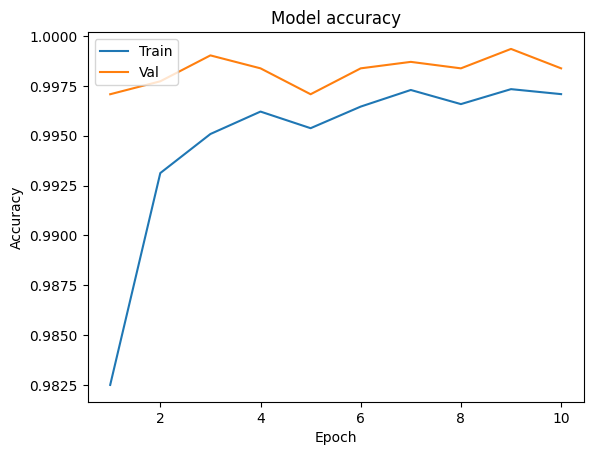

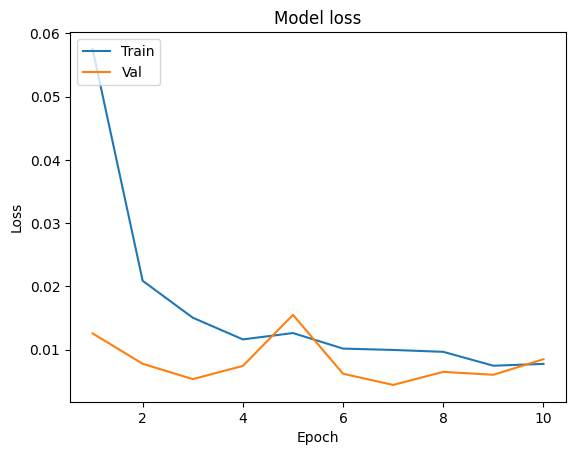

In [21]:
# compare training and validation accuracy
def plot_learningCurve(history, epoch):
    # Plot training & validation accuracy values
    epoch_range = range(1, epoch+1)
    plt.plot(epoch_range, history.history['accuracy'])
    plt.plot(epoch_range, history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
# plot accuracy comparison
plot_learningCurve(history, epochs)